
<font color="green">This notebook demonstrates three different computer vision techniques for automatically reading analog pressure</font>

### Method 1: Circular Hough Transform with Needle Detection:

- The Hough Circle Transform is a feature extraction technique that can detect circular objects in an image. 

- Use this approach to detect the circular on the gauge face.

Circle center: (950, 1166), Radius: 196
Circle center: (786, 1400), Radius: 198
Circle center: (680, 1294), Radius: 199
Circle center: (1130, 1420), Radius: 195
Circle center: (696, 1004), Radius: 186
Circle center: (830, 1498), Radius: 158
Circle center: (604, 1056), Radius: 199
Circle center: (846, 1126), Radius: 198
Circle center: (1082, 938), Radius: 199
Circle center: (1046, 1068), Radius: 195
Circle center: (662, 1146), Radius: 199
Circle center: (680, 1406), Radius: 191
Circle center: (1094, 1176), Radius: 197
Circle center: (988, 1488), Radius: 198
Circle center: (1212, 1356), Radius: 181
Circle center: (588, 1248), Radius: 194
Circle center: (1204, 1142), Radius: 199
Circle center: (576, 1382), Radius: 133
Circle center: (834, 830), Radius: 181
Circle center: (786, 942), Radius: 199
Circle center: (812, 1234), Radius: 158
Circle center: (902, 1428), Radius: 196
Circle center: (974, 1356), Radius: 165
Circle center: (560, 1148), Radius: 176
Circle center: (1226, 1018), Radius: 

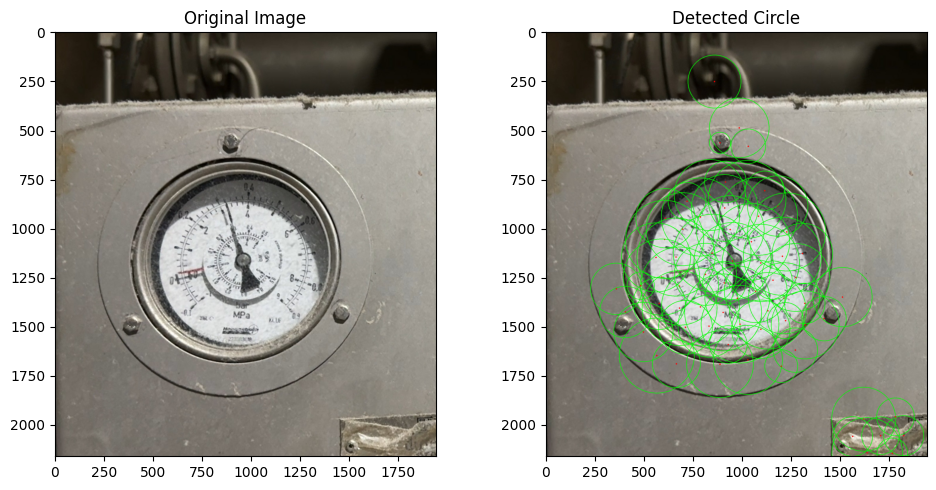

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_gauge_with_hough(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img_copy = img.copy()
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Hough Circle Transform to detect the gauge circle
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=100, 
        param1=50, 
        param2=30, 
        minRadius=50, 
        maxRadius=200
    )
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            # Draw the outer circle
            cv2.circle(img_copy, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(img_copy, (circle[0], circle[1]), 2, (0, 0, 255), 3)
            
            # Print circle parameters
            print(f"Circle center: ({circle[0]}, {circle[1]}), Radius: {circle[2]}")
    
    # Show the result
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(122), plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)), plt.title('Detected Circle')
    plt.tight_layout()
    plt.show()
    
    return img_copy, circles

# Test with your image
result_img, detected_circles = detect_gauge_with_hough(r"C:\Users\smith\Downloads\thermotune\g1.jpg")

### Method 2: Circular Hough Transform with Needle Detection

- This method extends the basic Hough Transform by adding needle detection using line detection techniques. 

- It helps us identifies the needle position.

Detected needle angle: 137.91 degrees


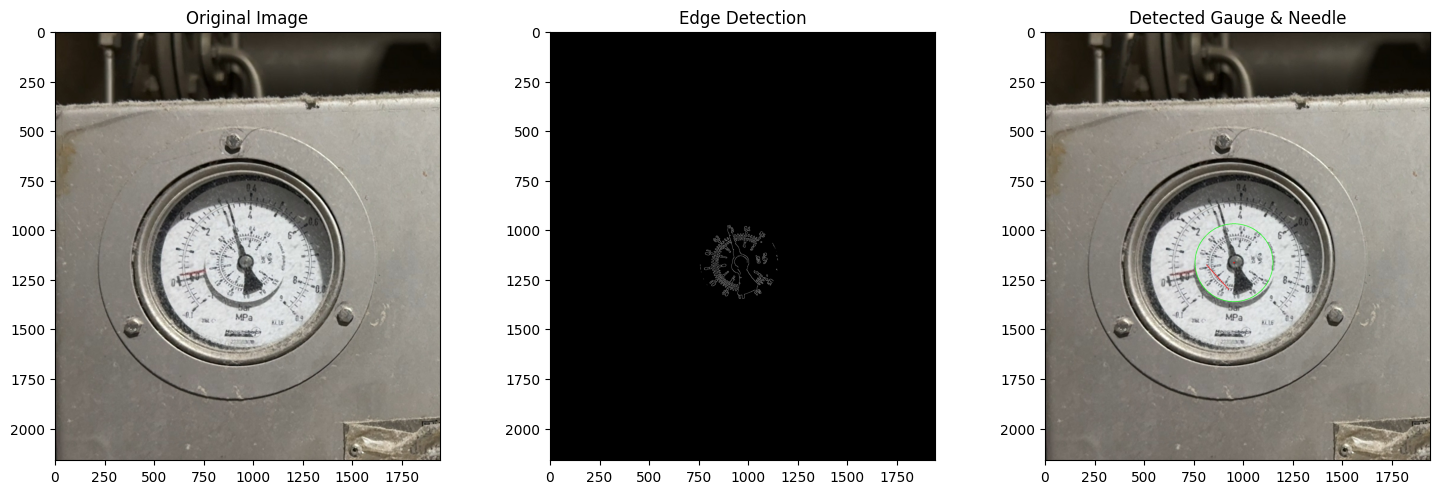

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def detect_gauge_and_needle(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img_copy = img.copy()
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Hough Circle Transform to detect the gauge circle
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=100, 
        param1=50, 
        param2=30, 
        minRadius=50, 
        maxRadius=200
    )
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circle = circles[0, 0]  # Use the first detected circle
        
        # Draw the outer circle
        cv2.circle(img_copy, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(img_copy, (circle[0], circle[1]), 2, (0, 0, 255), 3)
        
        # Create a mask for the gauge
        mask = np.zeros_like(gray)
        cv2.circle(mask, (circle[0], circle[1]), circle[2], 255, -1)
        
        # Apply Canny edge detection to find edges (including the needle)
        edges = cv2.Canny(blurred, 50, 150)
        edges = cv2.bitwise_and(edges, edges, mask=mask)
        
        # Apply Hough Line Transform to detect lines (including the needle)
        lines = cv2.HoughLinesP(
            edges, 
            rho=1, 
            theta=np.pi/180, 
            threshold=20, 
            minLineLength=circle[2]*0.5, 
            maxLineGap=10
        )
        
        # Find the needle by identifying the line passing closest to the center
        if lines is not None:
            # Prepare for needle identification
            center_point = np.array([circle[0], circle[1]])
            best_line = None
            min_distance = float('inf')
            
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # Calculate midpoint of the line
                mid_point = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
                # Calculate distance from midpoint to center
                distance = np.linalg.norm(mid_point - center_point)
                
                if distance < min_distance:
                    min_distance = distance
                    best_line = line[0]
            
            # Draw the needle (best line)
            if best_line is not None:
                x1, y1, x2, y2 = best_line
                cv2.line(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)
                
                # Calculate needle angle
                dx = x2 - x1
                dy = y2 - y1
                angle = math.atan2(dy, dx) * 180 / math.pi
                
                # Adjust angle to gauge convention (typically 0 at bottom, clockwise)
                adjusted_angle = (angle + 90) % 360
                print(f"Detected needle angle: {adjusted_angle:.2f} degrees")
    
    # Show the result
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(132), plt.imshow(edges, cmap='gray'), plt.title('Edge Detection')
    plt.subplot(133), plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)), plt.title('Detected Gauge & Needle')
    plt.tight_layout()
    plt.show()
    
    return img_copy

# Test with your image
result_img = detect_gauge_and_needle(r"C:\Users\smith\Downloads\thermotune\g1.jpg")

### Method 3: Polar Transformation Approach

- The Polar Transformation approach converts the circular gauge into a linear representation

- Making it easier to detect the needle position. This method is particularly robust against noise and varying lighting conditions.

Detected needle angle: 213.19 degrees
Estimated gauge reading: 0.79 MPa


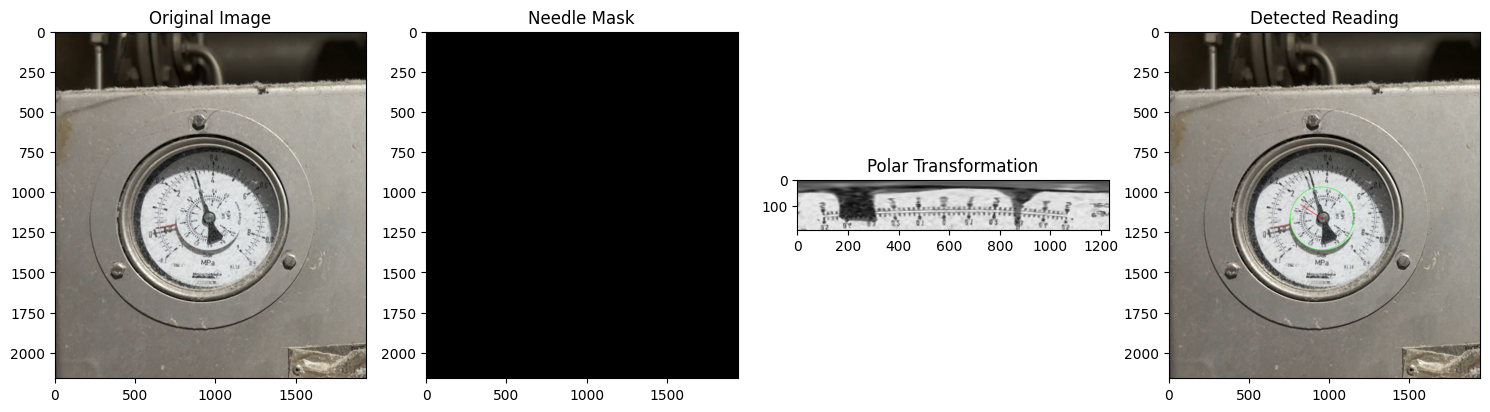

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def polar_transformation_gauge_reading(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img_copy = img.copy()
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Hough Circle Transform to detect the gauge circle
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=100, 
        param1=50, 
        param2=30, 
        minRadius=50, 
        maxRadius=200
    )
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        circle = circles[0, 0]  # Use the first detected circle
        center_x, center_y, radius = circle
        
        # Draw the circle on the original image
        cv2.circle(img_copy, (center_x, center_y), radius, (0, 255, 0), 2)
        cv2.circle(img_copy, (center_x, center_y), 2, (0, 0, 255), 3)
        
        # Apply color thresholding to isolate the red needle
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # Define range for red color (adjust these values based on your specific image)
        # Red wraps around in HSV, so we need two ranges
        lower_red1 = np.array([0, 70, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 70, 50])
        upper_red2 = np.array([180, 255, 255])
        
        # Create masks for red and combine them
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(mask1, mask2)
        
        # Create a circular mask for the gauge
        gauge_mask = np.zeros_like(gray)
        cv2.circle(gauge_mask, (center_x, center_y), radius, 255, -1)
        
        # Combine the red mask with the gauge mask
        final_mask = cv2.bitwise_and(red_mask, gauge_mask)
        
        # Apply polar transformation
        # Create an output image for polar transformation
        # The polar image height will be the radius, width will be the circumference
        polar_height = radius
        polar_width = int(2 * np.pi * radius)
        polar_img = np.zeros((polar_height, polar_width), dtype=np.uint8)
        
        # Perform the polar transformation manually
        for r in range(polar_height):
            for theta in range(polar_width):
                theta_rad = theta * (2 * np.pi / polar_width)
                x = int(center_x + (r * np.cos(theta_rad)))
                y = int(center_y + (r * np.sin(theta_rad)))
                
                # Check bounds
                if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                    polar_img[r, theta] = gray[y, x]
        
        # Find the position of the needle in polar space
        # Sum along radius dimension to find the angle with highest intensity
        column_sums = np.sum(polar_img, axis=0)
        needle_theta_index = np.argmax(column_sums)
        
        # Convert to angle in degrees
        needle_angle = (needle_theta_index * 360) / polar_width
        
        # Map to gauge reading based on scale (example: 0-270 degrees maps to 0-1.0 MPa)
        # This mapping needs to be calibrated for your specific gauge
        gauge_reading = needle_angle / 270.0  # Assuming 270 degree scale from 0 to 1.0
        
        # Draw the detected needle angle on the original image
        needle_length = radius * 0.8
        end_x = int(center_x + needle_length * np.cos(needle_angle * np.pi / 180))
        end_y = int(center_y + needle_length * np.sin(needle_angle * np.pi / 180))
        cv2.line(img_copy, (center_x, center_y), (end_x, end_y), (0, 0, 255), 2)
        
        print(f"Detected needle angle: {needle_angle:.2f} degrees")
        print(f"Estimated gauge reading: {gauge_reading:.2f} MPa")
    
    # Show the results
    plt.figure(figsize=(15, 5))
    plt.subplot(141), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(142), plt.imshow(final_mask, cmap='gray'), plt.title('Needle Mask')
    plt.subplot(143), plt.imshow(polar_img, cmap='gray'), plt.title('Polar Transformation')
    plt.subplot(144), plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)), plt.title('Detected Reading')
    plt.tight_layout()
    plt.show()
    
    return img_copy, needle_angle, gauge_reading

# Test with your image
result_img, angle, reading = polar_transformation_gauge_reading(r"C:\Users\smith\Downloads\thermotune\g1.jpg")